# Hough Transform

This notebook implements the classical Hough transform for detecting lines in an image. We later modify it to detect a set of lines in an image that most likely compose the borders of a Sudoku puzzle

In [1]:
import cv2
import numpy as np
from numpy import ndarray
from matplotlib import pyplot as plt
from python_helper_functions import CannyEdgeDetector
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from typing import *

print(f"OpenCV2 version: {cv2.__version__}")

OpenCV2 version: 4.11.0


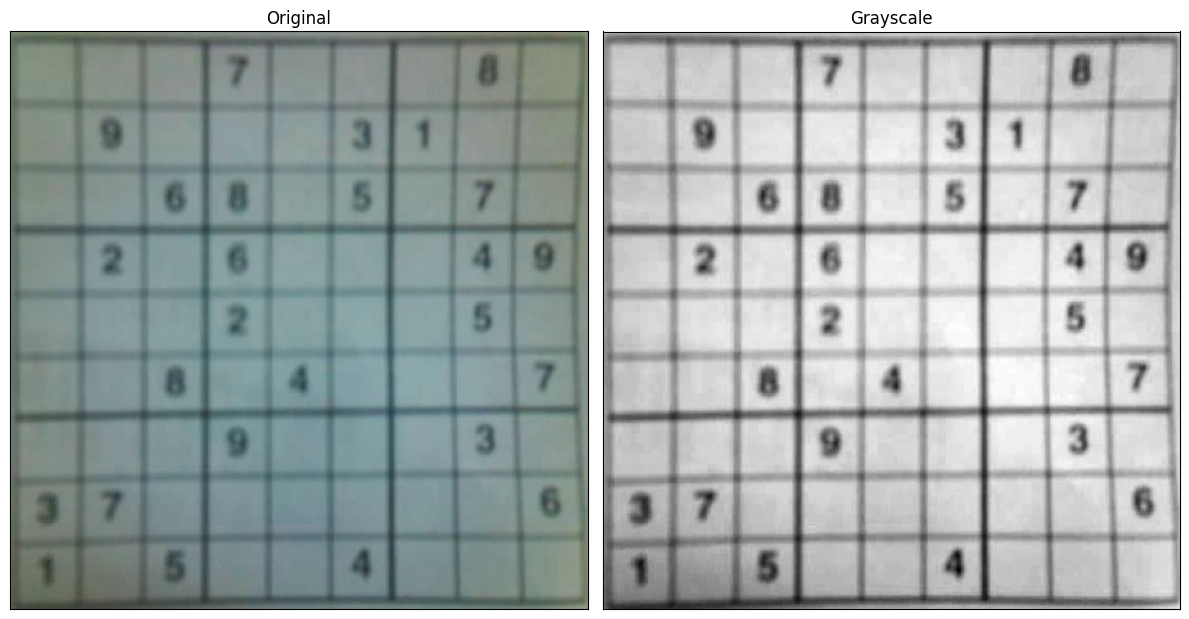

In [2]:
image_path = './warped_dataset/image1.jpg'

# Load and convert BGR → RGB
img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
# Load grayscale
bw = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original")
plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(bw, cmap='gray')  # invert grayscale
plt.title("Grayscale")
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

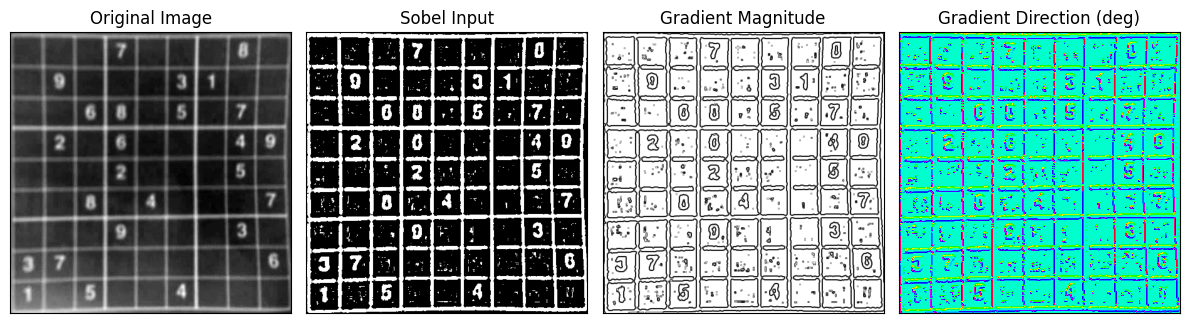

NameError: name 'canny_out' is not defined

In [3]:
# apply adaptive threshold
gray = cv2.adaptiveThreshold(bw, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                             cv2.THRESH_BINARY, 11, 2)

# Compute gradients using Sobel (same as Canny does internally)
grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

# Compute gradient magnitude and direction
magnitude = np.sqrt(grad_x**2 + grad_y**2)
direction = np.arctan2(grad_y, grad_x)  # radians

# Optional: normalize for visualization
magnitude_norm = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
direction_deg = np.degrees(direction)

# Show results
fig = plt.figure(figsize=(12, 8))

plt.subplot(1, 4, 1),plt.imshow(bw,'gray_r')
plt.title('Original Image')
plt.xticks([]),plt.yticks([])

plt.subplot(1, 4, 2),plt.imshow(gray,'gray_r')
plt.title('Sobel Input')
plt.xticks([]),plt.yticks([])

plt.subplot(1, 4, 3),plt.imshow(magnitude_norm,'gray_r')
plt.title('Gradient Magnitude')
plt.xticks([]),plt.yticks([])

plt.subplot(1, 4, 4),plt.imshow(direction_deg,'hsv')
plt.title('Gradient Direction (deg)')
plt.xticks([]),plt.yticks([])

plt.tight_layout()
plt.show()

print(f"Number close: {np.isclose(magnitude_norm, canny_out).sum()} / {canny_out.shape[0] * canny_out.shape[1]}")

Gradient magnitude min/max: 0.0/589.4488951554664
Gradient angle min/max: -180.0/180.0


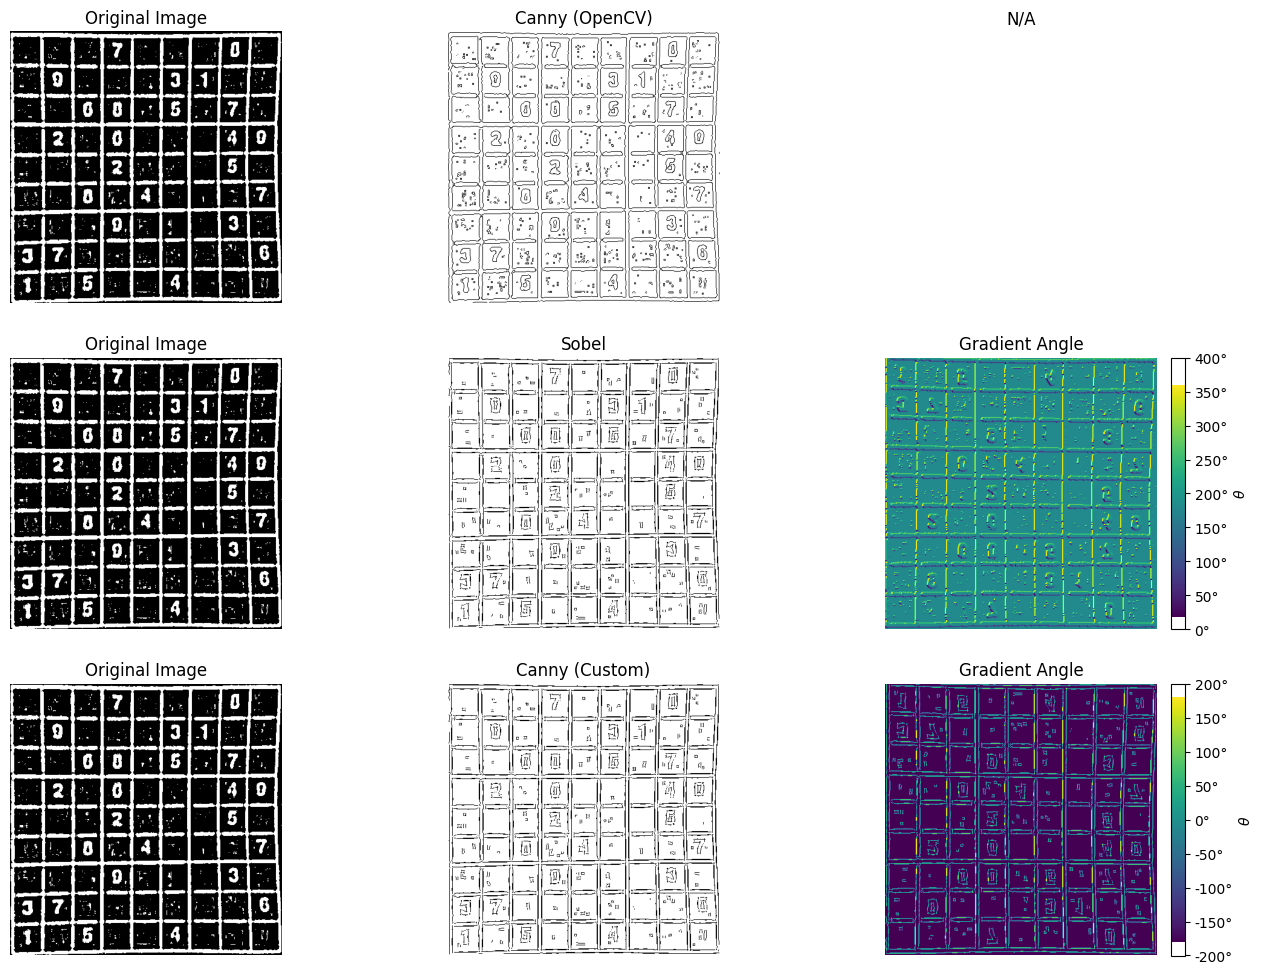

Number close: 182417 / 202500


In [8]:
# Load and preprocess image
gray = cv2.adaptiveThreshold(bw, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                             cv2.THRESH_BINARY, 11, 2)

# Apply the OpenCV Canny edge detector
canny_out = cv2.Canny(gray, 200, 250)

# Use Sobel to compute the gradients but don't use other steps as the Canny pipeline (e.g. Gaussian blur and hysterisis)
# Compute gradients using Sobel (same as Canny does internally)
sobel_grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobel_grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

# Compute gradient magnitude and direction
sobel_mag = np.sqrt(sobel_grad_x**2 + sobel_grad_y**2)
sobel_ang = np.rad2deg(np.arctan2(sobel_grad_y, sobel_grad_x)) + 180

# Apply our custom implementation of the Canny edge detector
ced = CannyEdgeDetector()
edges, mag, ang = ced(gray, 200, 250)

mag = np.where(edges > 0, mag, 0)
ang = np.where(edges > 0, ang, -180)
print(f"Gradient magnitude min/max: {np.amin(mag)}/{np.amax(mag)}")
print(f"Gradient angle min/max: {np.amin(ang)}/{np.amax(ang)}")

fig, axs = plt.subplots(3, 3, figsize=(16, 12))

ax1, ax2, ax3 = axs[0]
ax1.imshow(gray, cmap='gray_r')
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(canny_out, cmap='gray_r')
ax2.set_title('Canny (OpenCV)')
ax2.axis('off')

ax3.set_title('N/A')
ax3.axis('off')

ax1, ax2, ax3 = axs[1]
ax1.imshow(gray, cmap='gray_r')
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(edges, cmap='gray_r')
ax2.set_title('Sobel')
ax2.axis('off')

ax3_show = ax3.imshow(sobel_ang, origin='lower')
ax3.set_title('Gradient Angle')
ax3.axis('off')

cbar_ax = inset_axes(ax3,
                     width="5%",  # width = 5% of parent_bbox width
                     height="100%",  # height : same as parent_bbox height
                     loc='right',
                     borderpad=-2)
cbar = fig.colorbar(ax3_show, cax=cbar_ax, orientation='vertical', label=r"$\theta$")
ticks = cbar.get_ticks()
tick_labels = [f"{int(t)}°" for t in ticks]
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)

ax1, ax2, ax3 = axs[2]
ax1.imshow(gray, cmap='gray_r')
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(edges, cmap='gray_r')
ax2.set_title('Canny (Custom)')
ax2.axis('off')

ax3_show = ax3.imshow(ang, origin='lower')
ax3.set_title('Gradient Angle')
ax3.axis('off')

cbar_ax = inset_axes(ax3,
                     width="5%",  # width = 5% of parent_bbox width
                     height="100%",  # height : same as parent_bbox height
                     loc='right',
                     borderpad=-2)
cbar = fig.colorbar(ax3_show, cax=cbar_ax, orientation='vertical', label=r"$\theta$")
ticks = cbar.get_ticks()
tick_labels = [f"{int(t)}°" for t in ticks]
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)

plt.show()
print(f"Number close: {np.isclose(edges, canny_out).sum()} / {canny_out.shape[0] * canny_out.shape[1]}")

In [55]:
def hough_transform(img: cv2.Mat, n: int, m: int, verbose: bool = False):
    """

    :param img:
    :param n:           Number of bins for the radius.
    :param m:           Number of bins for the angles.
    :param verbose:
    :return:
    """
    accumulator = np.zeros((n, m), dtype=np.int32)
    gray = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                             cv2.THRESH_BINARY, 11, 2)
    ced = CannyEdgeDetector()
    edges, mag, ang = ced(gray, 200, 250)
    mag = np.where(edges > 0, mag, 0)
    ang = np.where(edges > 0, ang, 0)
    r_max = np.linalg.norm(np.array(img.shape))

    if verbose:
        print(f"Gradient magnitude min/max: {np.amin(mag)}/{np.amax(mag)}")
        print(f"Gradient angle min/max: {np.amin(ang)}/{np.amax(ang)}")

    for i in range(gray.shape[0]):
        for j in range(gray.shape[1]):
            g = gray[i, j]
            if g == 0:
                continue

            r_hat = int(np.linalg.norm(np.array([i, j])) * n / r_max)
            ang_hat = int(ang[i,j] * m / 360)
            print(f"r_hat {r_hat}, ang_hat {ang_hat}")
            accumulator[r_hat, ang_hat] += 1

    fig = plt.figure(figsize=(12, 8))
    plt.plot(accumulator)
    plt.show()

hough_transform(bw, 200, 250, verbose=True)

Gradient magnitude min/max: 0.0/589.4488951554664
Gradient angle min/max: 0.0/180.0
r_hat 0, ang_hat 0
r_hat 0, ang_hat 0
r_hat 0, ang_hat 0
r_hat 0, ang_hat 0
r_hat 1, ang_hat 0
r_hat 1, ang_hat 0
r_hat 1, ang_hat 0
r_hat 2, ang_hat 0
r_hat 2, ang_hat 0
r_hat 2, ang_hat 0
r_hat 3, ang_hat 0
r_hat 3, ang_hat 0
r_hat 3, ang_hat 0
r_hat 4, ang_hat 0
r_hat 4, ang_hat 0
r_hat 4, ang_hat 0
r_hat 5, ang_hat 0
r_hat 5, ang_hat 0
r_hat 5, ang_hat 0
r_hat 5, ang_hat 0
r_hat 6, ang_hat 0
r_hat 6, ang_hat 0
r_hat 6, ang_hat 0
r_hat 7, ang_hat 0
r_hat 7, ang_hat 0
r_hat 7, ang_hat 0
r_hat 8, ang_hat 0
r_hat 8, ang_hat 0
r_hat 8, ang_hat 0
r_hat 9, ang_hat 0
r_hat 9, ang_hat 0
r_hat 9, ang_hat 0
r_hat 10, ang_hat 0
r_hat 10, ang_hat 0
r_hat 10, ang_hat 0
r_hat 10, ang_hat 0
r_hat 11, ang_hat 0
r_hat 11, ang_hat 0
r_hat 11, ang_hat 0
r_hat 12, ang_hat 0
r_hat 12, ang_hat 0
r_hat 12, ang_hat 0
r_hat 13, ang_hat 0
r_hat 13, ang_hat 0
r_hat 13, ang_hat 0
r_hat 14, ang_hat 0
r_hat 14, ang_hat 0
r_hat 14

IndexError: index 250 is out of bounds for axis 1 with size 250